<a href="https://colab.research.google.com/github/JGRimst/Loadshedding/blob/main/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

from tensorflow import keras

from keras import layers
from keras import losses

from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:



data = pd.read_csv('/content/Final_eskom_vector_grid_health.csv')
data = pd.DataFrame(data)
data['Time'] = pd.to_datetime(data['DateTime'])
data.set_index('Time', inplace=True)




In [ ]:

# split_date = '2022-03-01'
# train = data[data.index < split_date]
# test = data[data.index >= split_date]




(26918, 15)

### Train test split

In [ ]:



Y_columns = [
    'ILS Usage',
    'MLR', 'IOS Excl ILS and MLR',
     'Total UCLF+OCLF'
]
Y = data[Y_columns].values
X = data.drop(columns=Y_columns, axis=1)
X.drop(['DateTime'], axis =1, inplace = True)
X = X.values

X_train_temp, X_test, Y_train_temp, Y_test = train_test_split(X, Y, test_size=0.10, shuffle=False, random_state=42)

# Then, split the temporary test set into validation (50%) and final test (50%)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_temp, Y_train_temp, test_size=0.10, shuffle=False, random_state=42)

# Print the shapes of the resulting sets
print("Training set (X_train, Y_train) shapes:", X_train.shape, Y_train.shape)
print("Validation set (X_val, Y_val) shapes:", X_val.shape, Y_val.shape)
print("Test set (X_test, Y_test) shapes:", X_test.shape, Y_test.shape)

Training set (X_train, Y_train) shapes: (18044, 15) (18044, 4)
Validation set (X_val, Y_val) shapes: (2005, 15) (2005, 4)
Test set (X_test, Y_test) shapes: (2228, 15) (2228, 4)


In [ ]:
# Y_columns = [
#     'ILS Usage',
#     'MLR', 'IOS Excl ILS and MLR',
#      'Total UCLF+OCLF'
# ]
# Y_train = train[Y_columns].values
# X_train = train.drop(columns=Y_columns, axis=1)
# X_train.drop(['DateTime'], axis =1, inplace = True)
# X_train = X_train.values

# Y_test = test[Y_columns].values
# X_test = test.drop(columns=Y_columns, axis=1)
# X_test.drop(['DateTime'], axis =1, inplace = True)
# X_test = X_test.values

### Standardising the input values

In [ ]:
scaler = StandardScaler()
X_train_normalised = scaler.fit_transform(X_train)
X_test_normalised = scaler.transform(X_test)
X_val_norm = scaler.transform(X_val)

Y_train_normalised = scaler.fit_transform(Y_train)
Y_test_normalised = scaler.transform(Y_test)
Y_val_norm = scaler.transform(Y_val)

### Putting into sequence of weeks (window length)

In [ ]:
# # split a multivariate sequence into samples
# def split_multivar_sequences(sequenceX, sequenceY, n_steps):
#     X, y = list(), list()
#     for i in range(len(sequenceX)):
#         # find the end of this pattern
#         end_idx = i + n_steps
#         # check if we are beyond the dataset
#         if end_idx > len(sequenceY)-1:
#             break
#         # gather input and output parts of the pattern
#         seq_x, seq_y = sequenceX[i:end_idx, :], sequenceY[end_idx]
#         X.append(seq_x)
#         y.append(seq_y)
#     return np.array(X), np.array(y)

# timesteps = 24*7
# X_train_seq_weeks, Y_train_seq_weeks = split_multivar_sequences(X_train_normalised, Y_train_normalised, timesteps)
# X_test_seq_weeks, Y_test_seq_weeks = split_multivar_sequences(X_test_normalised, Y_test_normalised, timesteps)



In [ ]:
timesteps = 24*7
window_length = timesteps
batch_size = 16
num_features = 15
train_generator = TimeseriesGenerator(X_train_normalised, Y_train_normalised,length=window_length, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test_normalised, Y_test_normalised,length=window_length, batch_size=batch_size)
val_generator = TimeseriesGenerator(X_val_norm, Y_val_norm, length=window_length, batch_size=batch_size)

In [ ]:
(train_generator[0])

(array([[[-1.01847499, -0.68542134, -0.03411242, ...,  1.12124769,
          -1.00739482, -0.91654215],
         [-1.38394209, -0.84427245, -0.03411242, ...,  1.12124769,
          -1.06296276, -0.91654215],
         [-1.68061538, -0.88073827, -0.03411242, ...,  1.12124769,
          -1.05833209, -0.91654215],
         ...,
         [-0.90668505,  0.16189944, -0.03411242, ...,  1.13380119,
          -1.06759342, -0.91654215],
         [-0.94538157, -0.36971726, -0.03411242, ...,  1.13455529,
          -1.05634752, -0.91654215],
         [-0.90668505, -0.92278885, -0.03411242, ...,  1.13262569,
          -1.00474873, -0.91654215]],
 
        [[-1.38394209, -0.84427245, -0.03411242, ...,  1.12124769,
          -1.06296276, -0.91654215],
         [-1.68061538, -0.88073827, -0.03411242, ...,  1.12124769,
          -1.05833209, -0.91654215],
         [-1.79240531, -0.84177479, -0.03411242, ...,  1.12153603,
          -1.05105534, -0.91654215],
         ...,
         [-0.94538157, -0.3697172

In [ ]:
# print('(n_samples, n_steps, n_features)')
# print(f'Shape of X: {(X_train_seq_weeks).shape}')
# print(f'Shape of Y: {(Y_train_seq_weeks).shape}')


# print(f'Shape of X: {(X_test_seq_weeks).shape}')
# print(f'Shape of Y: {(Y_test_seq_weeks).shape}')

(n_samples, n_steps, n_features)
Shape of X: (25392, 168, 15)
Shape of Y: (25392, 4)
Shape of X: (7920, 168, 15)
Shape of Y: (7920, 4)


# Model Building (Single LTSM 32 Units)

In [ ]:
patience = 2 #num epochs without improvement

model = tf.keras.Sequential([
  layers.LSTM(32, input_shape = (window_length, 15), return_sequences=False, activation='tanh'),
  layers.Dropout(0.2),
  layers.Dense(4, activation='linear')])

model.build((None, timesteps, 15))
model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=patience, mode='min', verbose=True, restore_best_weights=True)


model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 32)                6144      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 6276 (24.52 KB)
Trainable params: 6276 (24.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(train_generator, epochs=5, validation_data= val_generator,  callbacks=[early_stopping], verbose=1)


Epoch 1/5
1693/1693 [==============================] - 37s 21ms/step - loss: 0.8364 - mean_absolute_error: 0.4502 - val_loss: 1.3293 - val_mean_absolute_error: 0.6123
Epoch 2/5
1693/1693 [==============================] - 39s 23ms/step - loss: 0.6947 - mean_absolute_error: 0.3922 - val_loss: 1.4101 - val_mean_absolute_error: 0.6420
Epoch 3/5
1693/1693 [==============================] - 40s 23ms/step - loss: 0.6351 - mean_absolute_error: 0.3674 - val_loss: 1.2203 - val_mean_absolute_error: 0.5993
Epoch 4/5
1693/1693 [==============================] - 40s 23ms/step - loss: 0.5986 - mean_absolute_error: 0.3544 - val_loss: 1.1636 - val_mean_absolute_error: 0.5692
Epoch 5/5
1693/1693 [==============================] - 40s 24ms/step - loss: 0.5815 - mean_absolute_error: 0.3422 - val_loss: 1.0879 - val_mean_absolute_error: 0.5586


## Bidirectional LTSM 32 Units

In [ ]:
patience = 2 #num epochs without improvement

model = tf.keras.Sequential([
  layers.Bidirectional(
  layers.LSTM(32, input_shape = (window_length, 15), return_sequences=False, activation='tanh')),
  layers.Dropout(0.2),
  layers.Dense(4, activation='linear')])

model.build((None, timesteps, 15))
model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=patience, mode='min', verbose=True, restore_best_weights=True)


model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 64)                12288     
 al)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 4)                 260       
                                                                 
Total params: 12548 (49.02 KB)
Trainable params: 12548 (49.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
bi_history = model.fit(train_generator, epochs=5, validation_data= val_generator,  callbacks=[early_stopping], verbose=1)

Epoch 1/5
1693/1693 [==============================] - 57s 32ms/step - loss: 0.8005 - mean_absolute_error: 0.4499 - val_loss: 1.5454 - val_mean_absolute_error: 0.6923
Epoch 2/5
1693/1693 [==============================] - 61s 36ms/step - loss: 0.6590 - mean_absolute_error: 0.3898 - val_loss: 1.2863 - val_mean_absolute_error: 0.6235
Epoch 3/5
1693/1693 [==============================] - 61s 36ms/step - loss: 0.5990 - mean_absolute_error: 0.3625 - val_loss: 1.1672 - val_mean_absolute_error: 0.6052
Epoch 4/5
1693/1693 [==============================] - 60s 36ms/step - loss: 0.5696 - mean_absolute_error: 0.3472 - val_loss: 1.0568 - val_mean_absolute_error: 0.5923
Epoch 5/5
1693/1693 [==============================] - 66s 39ms/step - loss: 0.5405 - mean_absolute_error: 0.3329 - val_loss: 1.1453 - val_mean_absolute_error: 0.6261


### Deep model standard LTSM

In [ ]:
patience = 8 #num epochs without improvement

model = tf.keras.Sequential([
  layers.LSTM(64, input_shape = (window_length, 15), return_sequences=True, activation='tanh'),
  layers.Dropout(0.2),
  layers.LSTM(32, input_shape = (window_length, 15)),
  layers.Dropout(0.2),
  layers.Dense(4, activation='linear')])

model.build((None, timesteps, 15))
model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', verbose=True, restore_best_weights=True)


model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 168, 64)           20480     
                                                                 
 dropout_4 (Dropout)         (None, 168, 64)           0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 33028 (129.02 KB)
Trainable params: 33028 (129.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
deep_history = model.fit(train_generator, epochs=100, validation_data= val_generator,  callbacks=[early_stopping], verbose=1)

Epoch 1/100
1118/1118 [==============================] - 22s 15ms/step - loss: 0.8427 - mean_absolute_error: 0.4310 - val_loss: 1.0064 - val_mean_absolute_error: 0.5377
Epoch 2/100
1118/1118 [==============================] - 19s 17ms/step - loss: 0.7359 - mean_absolute_error: 0.3816 - val_loss: 0.9442 - val_mean_absolute_error: 0.5129
Epoch 3/100
1118/1118 [==============================] - 21s 19ms/step - loss: 0.6479 - mean_absolute_error: 0.3512 - val_loss: 1.0360 - val_mean_absolute_error: 0.4799
Epoch 4/100
1118/1118 [==============================] - 16s 14ms/step - loss: 0.5924 - mean_absolute_error: 0.3283 - val_loss: 1.0313 - val_mean_absolute_error: 0.4596
Epoch 5/100
1118/1118 [==============================] - 17s 15ms/step - loss: 0.5654 - mean_absolute_error: 0.3194 - val_loss: 0.8475 - val_mean_absolute_error: 0.4483
Epoch 6/100
1118/1118 [==============================] - 16s 14ms/step - loss: 0.5356 - mean_absolute_error: 0.3092 - val_loss: 0.8871 - val_mean_absolute_

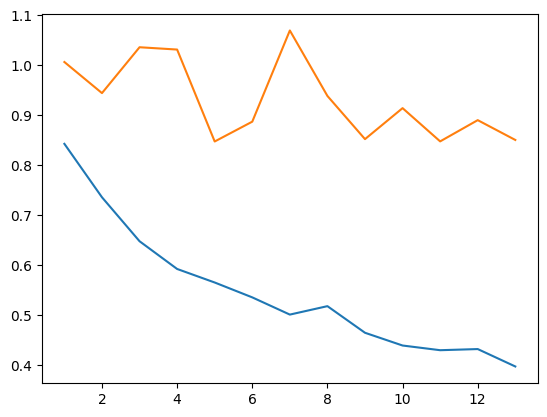

In [ ]:
history_dict = deep_history.history


error = history_dict['mean_absolute_error']
val_error = history_dict['val_mean_absolute_error']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(error) + 1)

# Plot training loss with dots
plt.plot(epochs, loss)

# Plot validation loss with lines
plt.plot(epochs, val_loss, '-', label=f'Main model - Validation loss')

### Deep model bi directional LTSM

In [ ]:
patience = 2 #num epochs without improvement

model = tf.keras.Sequential([
  layers.Bidirectional(
  layers.LSTM(32, input_shape = (window_length, 15), return_sequences=True, activation='tanh')),
  layers.Dropout(0.2),
  layers.Bidirectional(
  layers.LSTM(32,  return_sequences=False)),
  layers.Dropout(0.2),
  layers.Dense(4, activation='linear')])

model.build((None, timesteps, 15))
model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=patience, mode='min', verbose=True, restore_best_weights=True)


model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 168, 64)           12288     
 onal)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 168, 64)           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 4)                 260       
                                                                 
Total params: 37380 (146.02 KB)
Trainable params: 3738

In [ ]:
deep_history_bi = model.fit(train_generator, epochs=5, validation_data= val_generator,  callbacks=[early_stopping], verbose=1)

Epoch 1/5
1693/1693 [==============================] - 142s 81ms/step - loss: 0.7776 - mean_absolute_error: 0.4286 - val_loss: 1.6222 - val_mean_absolute_error: 0.6613
Epoch 2/5
1693/1693 [==============================] - 137s 81ms/step - loss: 0.6329 - mean_absolute_error: 0.3670 - val_loss: 1.1727 - val_mean_absolute_error: 0.5813
Epoch 3/5
1693/1693 [==============================] - 145s 86ms/step - loss: 0.5717 - mean_absolute_error: 0.3325 - val_loss: 1.0787 - val_mean_absolute_error: 0.5646
Epoch 4/5
1693/1693 [==============================] - 142s 84ms/step - loss: 0.5222 - mean_absolute_error: 0.3114 - val_loss: 0.9722 - val_mean_absolute_error: 0.5279
Epoch 5/5
1693/1693 [==============================] - 146s 86ms/step - loss: 0.4953 - mean_absolute_error: 0.3030 - val_loss: 1.0038 - val_mean_absolute_error: 0.5241


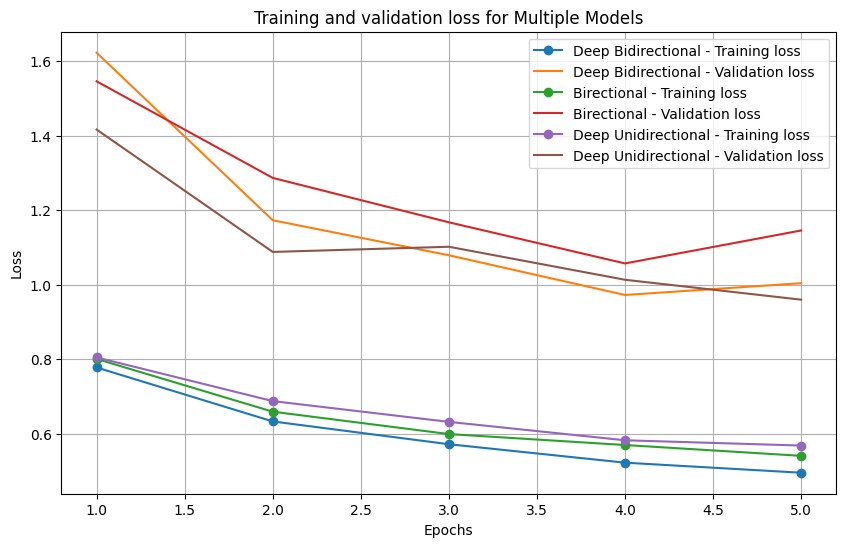

In [ ]:
history_dicts = [deep_history_bi.history, history.history, deep_history.history]

# Define labels for each model
model_labels = ['Deep Bidirectional', 'Birectional', 'Deep Unidirectional']

# Create a new figure
plt.figure(figsize=(10, 6))

# Loop through each model's history
for i, history_dict in enumerate(history_dicts):
    error = history_dict['mean_absolute_error']
    val_error = history_dict['val_mean_absolute_error']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(error) + 1)

    # Plot training loss with dots
    plt.plot(epochs, loss, 'o-', label=f'{model_labels[i]} - Training loss')

    # Plot validation loss with lines
    plt.plot(epochs, val_loss, '-', label=f'{model_labels[i]} - Validation loss')

plt.title('Training and validation loss for Multiple Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()


## Model making

### Deep bidirectional with more epochs and more units

In [ ]:
patience = 10 #num epochs without improvement

model = tf.keras.Sequential([
  layers.Bidirectional(
  layers.LSTM(32, input_shape = (window_length, 15), return_sequences=True, activation='tanh')),
  layers.Dropout(0.2),
  layers.LSTM(32,  return_sequences=False),
  layers.Dropout(0.2),
  layers.Dense(4, activation='linear')])

model.build((None, timesteps, 15))
model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', verbose=True, restore_best_weights=True)


model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 168, 128)          40960     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 168, 128)          0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                20608     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 61700 (241.02 KB)
Trainable params: 61700 (241.02 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
model_history_64 = model.fit(train_generator, epochs=100, validation_data= val_generator,  callbacks=[early_stopping], verbose=1)

Epoch 1/100
1118/1118 [==============================] - 30s 21ms/step - loss: 0.8229 - mean_absolute_error: 0.4294 - val_loss: 0.9516 - val_mean_absolute_error: 0.4973
Epoch 2/100
1118/1118 [==============================] - 24s 21ms/step - loss: 0.6976 - mean_absolute_error: 0.3793 - val_loss: 1.0691 - val_mean_absolute_error: 0.4775
Epoch 3/100
1118/1118 [==============================] - 24s 21ms/step - loss: 0.6024 - mean_absolute_error: 0.3403 - val_loss: 1.0872 - val_mean_absolute_error: 0.5173
Epoch 4/100
1118/1118 [==============================] - 23s 20ms/step - loss: 0.5740 - mean_absolute_error: 0.3278 - val_loss: 0.9807 - val_mean_absolute_error: 0.5277
Epoch 5/100
1118/1118 [==============================] - 22s 20ms/step - loss: 0.5264 - mean_absolute_error: 0.3080 - val_loss: 1.0713 - val_mean_absolute_error: 0.5279
Epoch 6/100
1118/1118 [==============================] - 22s 20ms/step - loss: 0.4954 - mean_absolute_error: 0.2991 - val_loss: 0.9469 - val_mean_absolute_

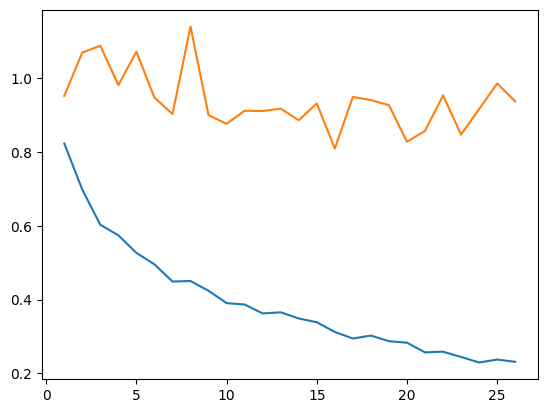

In [ ]:
history_dict = model_history_64.history


error = history_dict['mean_absolute_error']
val_error = history_dict['val_mean_absolute_error']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(error) + 1)

# Plot training loss with dots
plt.plot(epochs, loss)

# Plot validation loss with lines
plt.plot(epochs, val_loss, '-', label=f'Main model - Validation loss')


### Model with Huber loss function (deep bidirectional)[link text](https://)

In [ ]:
patience = 10 #num epochs without improvement

model2 = tf.keras.Sequential([
  layers.Bidirectional(
  layers.LSTM(32, input_shape = (window_length, 15), return_sequences=True, activation='tanh')),
  layers.Dropout(0.2),
  layers.LSTM(32,  return_sequences=False),
  layers.Dropout(0.2),
  layers.Dense(4, activation='linear')])

model2.build((None, timesteps, 15))
model2.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', verbose=True, restore_best_weights=True)


model2.compile(loss=tf.keras.losses.Huber(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.losses.Huber()])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirecti  (None, 168, 64)           12288     
 onal)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 168, 64)           0         
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 4)                 132       
                                                                 
Total params: 24836 (97.02 KB)
Trainable params: 24836 (97.02 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [ ]:
model_history_Huber = model2.fit(train_generator, epochs=100, validation_data= val_generator,  callbacks=[early_stopping], verbose=1)

Epoch 1/100
1118/1118 [==============================] - 29s 20ms/step - loss: 0.1927 - huber_loss: 0.1934 - val_loss: 0.2777 - val_huber_loss: 0.2773
Epoch 2/100
1118/1118 [==============================] - 22s 20ms/step - loss: 0.1646 - huber_loss: 0.1654 - val_loss: 0.2666 - val_huber_loss: 0.2663
Epoch 3/100
1118/1118 [==============================] - 22s 20ms/step - loss: 0.1601 - huber_loss: 0.1608 - val_loss: 0.2519 - val_huber_loss: 0.2516
Epoch 4/100
1118/1118 [==============================] - 23s 21ms/step - loss: 0.1506 - huber_loss: 0.1513 - val_loss: 0.2688 - val_huber_loss: 0.2685
Epoch 5/100
1118/1118 [==============================] - 23s 21ms/step - loss: 0.1396 - huber_loss: 0.1403 - val_loss: 0.2626 - val_huber_loss: 0.2623
Epoch 6/100
1118/1118 [==============================] - 22s 19ms/step - loss: 0.1333 - huber_loss: 0.1340 - val_loss: 0.2647 - val_huber_loss: 0.2645
Epoch 7/100
1118/1118 [==============================] - 22s 20ms/step - loss: 0.1287 - huber_

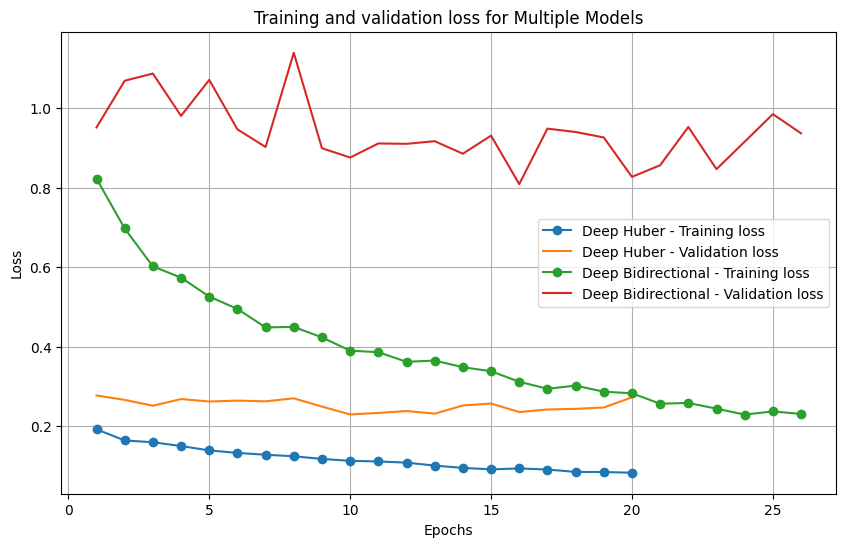

In [ ]:
history_dicts = [model_history_Huber.history, model_history_64.history]

# Define labels for each model
model_labels = ['Deep Huber', 'Deep Bidirectional']

errors = [model_history_Huber.history['huber_loss'], model_history_64.history['mean_absolute_error']]
val_errors = [model_history_Huber.history['val_huber_loss'], model_history_64.history['val_mean_absolute_error']]
losses = [model_history_Huber.history['loss'], model_history_64.history['loss']]
val_losses = [model_history_Huber.history['val_loss'], model_history_64.history['val_loss']]

# Create a new figure
plt.figure(figsize=(10, 6))

# Loop through each model's history
for i, history_dict in enumerate(history_dicts):
    error = errors[i]
    val_error = val_errors[i]
    loss = losses[i]
    val_loss = val_losses[i]

    epochs = range(1, len(error) + 1)

    # Plot training loss with dots
    plt.plot(epochs, loss, 'o-', label=f'{model_labels[i]} - Training loss')

    # Plot validation loss with lines
    plt.plot(epochs, val_loss, '-', label=f'{model_labels[i]} - Validation loss')

plt.title('Training and validation loss for Multiple Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

### Hyperparameter tuning of delta (set to 0.3 -> more robust to outliers)

In [ ]:
patience = 10 #num epochs without improvement

modelH03 = tf.keras.Sequential([
  layers.Bidirectional(
  layers.LSTM(32, input_shape = (window_length, 15), return_sequences=True, activation='tanh')),
  layers.Dropout(0.2),
  layers.LSTM(32,  return_sequences=False),
  layers.Dropout(0.2),
  layers.Dense(4, activation='linear')])

modelH03.build((None, timesteps, 15))
modelH03.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', verbose=True, restore_best_weights=True)


modelH03.compile(loss=tf.keras.losses.Huber(delta=0.3),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.losses.Huber()])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirecti  (None, 168, 64)           12288     
 onal)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 168, 64)           0         
                                                                 
 lstm_13 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 4)                 132       
                                                                 
Total params: 24836 (97.02 KB)
Trainable params: 24836 (97.02 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [ ]:
model_history_H03 = modelH03.fit(train_generator, epochs=100, validation_data= val_generator,  callbacks=[early_stopping], verbose=1)

Epoch 1/100
1118/1118 [==============================] - 29s 21ms/step - loss: 0.0794 - huber_loss: 0.1928 - val_loss: 0.1190 - val_huber_loss: 0.3052
Epoch 2/100
1118/1118 [==============================] - 23s 21ms/step - loss: 0.0691 - huber_loss: 0.1710 - val_loss: 0.1276 - val_huber_loss: 0.3295
Epoch 3/100
1118/1118 [==============================] - 22s 19ms/step - loss: 0.0654 - huber_loss: 0.1613 - val_loss: 0.1080 - val_huber_loss: 0.2742
Epoch 4/100
1118/1118 [==============================] - 23s 21ms/step - loss: 0.0617 - huber_loss: 0.1509 - val_loss: 0.1102 - val_huber_loss: 0.2808
Epoch 5/100
1118/1118 [==============================] - 22s 20ms/step - loss: 0.0589 - huber_loss: 0.1433 - val_loss: 0.1015 - val_huber_loss: 0.2461
Epoch 6/100
1118/1118 [==============================] - 22s 19ms/step - loss: 0.0565 - huber_loss: 0.1373 - val_loss: 0.1134 - val_huber_loss: 0.2727
Epoch 7/100
1118/1118 [==============================] - 22s 20ms/step - loss: 0.0533 - huber_

### Hyperparameter tuning of delta (set to 0.5 -> more robust to outliers

In [ ]:
patience = 10 #num epochs without improvement

modelH05 = tf.keras.Sequential([
  layers.Bidirectional(
  layers.LSTM(32, input_shape = (window_length, 15), return_sequences=True, activation='tanh')),
  layers.Dropout(0.2),
  layers.LSTM(32,  return_sequences=False),
  layers.Dropout(0.2),
  layers.Dense(4, activation='linear')])

modelH05.build((None, timesteps, 15))
modelH05.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', verbose=True, restore_best_weights=True)


modelH05.compile(loss=tf.keras.losses.Huber(delta=0.5),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.losses.Huber()])

model_history_H05 = modelH05.fit(train_generator, epochs=100, validation_data= val_generator,  callbacks=[early_stopping], verbose=1)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_7 (Bidirecti  (None, 168, 64)           12288     
 onal)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 168, 64)           0         
                                                                 
 lstm_15 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_15 (Dropout)        (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 4)                 132       
                                                                 
Total params: 24836 (97.02 KB)
Trainable params: 24836 (97.02 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

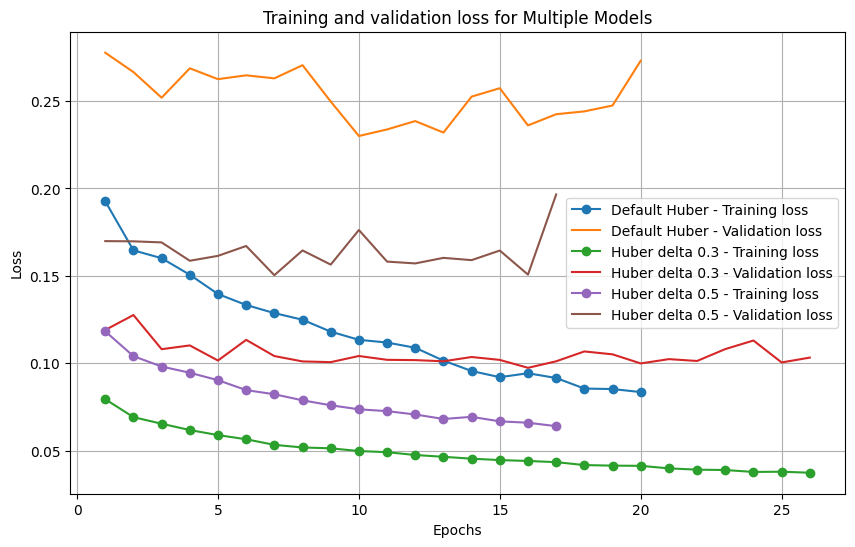

In [ ]:
history_dicts = [model_history_Huber.history, model_history_H03.history, model_history_H05.history]

# Define labels for each model
model_labels = ['Default Huber', 'Huber delta 0.3', 'Huber delta 0.5']

# Create a new figure
plt.figure(figsize=(10, 6))

# Loop through each model's history
for i, history_dict in enumerate(history_dicts):
    error = history_dict['huber_loss']
    val_error = history_dict['val_huber_loss']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(error) + 1)

    # Plot training loss with dots
    plt.plot(epochs, loss, 'o-', label=f'{model_labels[i]} - Training loss')

    # Plot validation loss with lines
    plt.plot(epochs, val_loss, '-', label=f'{model_labels[i]} - Validation loss')

plt.title('Training and validation loss for Multiple Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()


Huber with delta 0.3 is seen to be the best according to validation and training loss.  Thus move onto deciding on architecture of the model (Depth and bidirectionality)

### Deep model with 1 birectional layer

In [ ]:
patience = 10 #num epochs without improvement

huber03Model_deep = tf.keras.Sequential([
  layers.Bidirectional(
  layers.LSTM(16, input_shape = (window_length, 15), return_sequences=True, activation='tanh')),
  layers.Dropout(0.2),
  layers.LSTM(16,  return_sequences=True),
  layers.Dropout(0.2),
  layers.LSTM(16,  return_sequences=False),
  layers.Dropout(0.2),
  layers.Dense(4, activation='linear')])

huber03Model_deep.build((None, timesteps, 15))
huber03Model_deep.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', verbose=True, restore_best_weights=True)


huber03Model_deep.compile(loss=tf.keras.losses.Huber(delta=0.3),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.losses.Huber()])
model_history_H03 = huber03Model_deep.fit(train_generator, epochs=100, validation_data= val_generator,  callbacks=[early_stopping], verbose=1)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_19 (Bidirect  (None, 168, 32)           4096      
 ional)                                                          
                                                                 
 dropout_35 (Dropout)        (None, 168, 32)           0         
                                                                 
 lstm_36 (LSTM)              (None, 168, 16)           3136      
                                                                 
 dropout_36 (Dropout)        (None, 168, 16)           0         
                                                                 
 lstm_37 (LSTM)              (None, 16)                2112      
                                                                 
 dropout_37 (Dropout)        (None, 16)                0         
                                                     

### Deep model with 2 birectional layers

In [ ]:
patience = 5 #num epochs without improvement

huber03Model_2Bid = tf.keras.Sequential([
  layers.Bidirectional(
  layers.LSTM(16, input_shape = (window_length, 15), return_sequences=True, activation='tanh')),
  layers.Dropout(0.2),
  layers.Bidirectional(layers.LSTM(16,  return_sequences=True)),
  layers.Dropout(0.2),
  layers.LSTM(16,  return_sequences=False),
  layers.Dropout(0.2),
  layers.Dense(4, activation='linear')])

huber03Model_2Bid.build((None, timesteps, 15))
huber03Model_2Bid.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', verbose=True, restore_best_weights=True)


huber03Model_2Bid.compile(loss=tf.keras.losses.Huber(delta=0.3),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.losses.Huber()])
model_history_H03_2 = huber03Model_2Bid.fit(train_generator, epochs=100, validation_data= val_generator,  callbacks=[early_stopping], verbose=1)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_20 (Bidirect  (None, 168, 32)           4096      
 ional)                                                          
                                                                 
 dropout_38 (Dropout)        (None, 168, 32)           0         
                                                                 
 bidirectional_21 (Bidirect  (None, 168, 32)           6272      
 ional)                                                          
                                                                 
 dropout_39 (Dropout)        (None, 168, 32)           0         
                                                                 
 lstm_40 (LSTM)              (None, 16)                3136      
                                                                 
 dropout_40 (Dropout)        (None, 16)              

### Deep model with 2 birectional but only 2 layers

In [ ]:
patience = 5 #num epochs without improvement

huber03Model_2 = tf.keras.Sequential([
  layers.Bidirectional(
  layers.LSTM(16, input_shape = (window_length, 15), return_sequences=True, activation='tanh')),
  layers.Dropout(0.2),
  layers.Bidirectional(layers.LSTM(16,  return_sequences=False)),
  layers.Dropout(0.2),
  layers.Dense(4, activation='linear')])

huber03Model_2.build((None, timesteps, 15))
huber03Model_2.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', verbose=True, restore_best_weights=True)


huber03Model_2.compile(loss=tf.keras.losses.Huber(delta=0.3),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.losses.Huber()])
model_history_H03_3 = huber03Model_2.fit(train_generator, epochs=100, validation_data= val_generator,  callbacks=[early_stopping], verbose=1)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_22 (Bidirect  (None, 168, 32)           4096      
 ional)                                                          
                                                                 
 dropout_41 (Dropout)        (None, 168, 32)           0         
                                                                 
 bidirectional_23 (Bidirect  (None, 32)                6272      
 ional)                                                          
                                                                 
 dropout_42 (Dropout)        (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 4)                 132       
                                                                 
Total params: 10500 (41.02 KB)
Trainable params: 1050

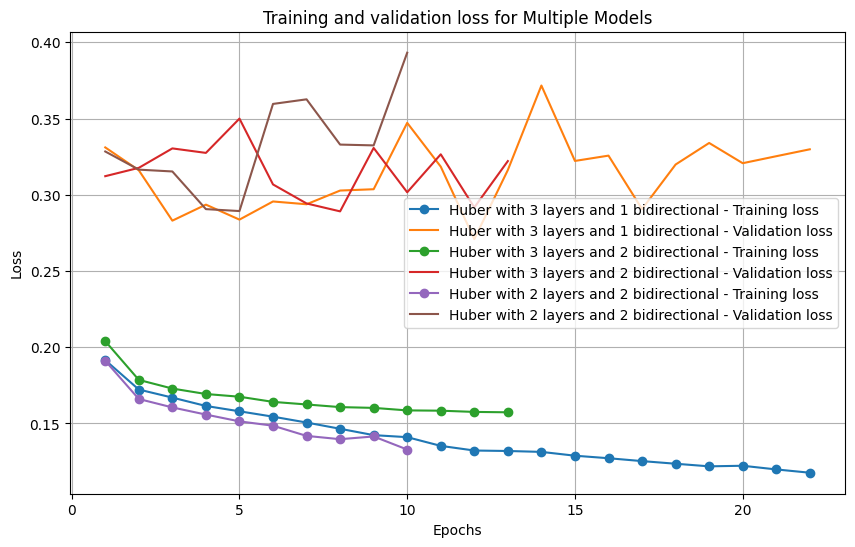

In [ ]:
history_dicts = [model_history_H03.history, model_history_H03_2.history, model_history_H03_3.history]

# Define labels for each model
model_labels = ['Huber with 3 layers and 1 bidirectional', 'Huber with 3 layers and 2 bidirectional', 'Huber with 2 layers and 2 bidirectional']

# Create a new figure
plt.figure(figsize=(10, 6))

# Loop through each model's history
for i, history_dict in enumerate(history_dicts):
    error = history_dict['huber_loss']
    val_error = history_dict['val_huber_loss']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(error) + 1)

    # Plot training loss with dots
    plt.plot(epochs, error, 'o-', label=f'{model_labels[i]} - Training loss')

    # Plot validation loss with lines
    plt.plot(epochs, val_error, '-', label=f'{model_labels[i]} - Validation loss')

plt.title('Training and validation loss for Multiple Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

best type is seen as 3 layers with 2 bidirectional

In [ ]:
patience = 5 #num epochs without improvement

model_3_2bi = tf.keras.Sequential([
  layers.Bidirectional(
  layers.LSTM(8, input_shape = (window_length, 15), return_sequences=True, activation='tanh')),
  layers.Dropout(0.2),
  layers.Bidirectional(layers.LSTM(8,  return_sequences=True)),
  layers.Dropout(0.2),
  layers.LSTM(4,  return_sequences=False),
  layers.Dropout(0.2),
  layers.Dense(4, activation='linear')])

model_3_2bi.build((None, timesteps, 15))
model_3_2bi.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_huber_loss', patience=patience, mode='min', verbose=True, restore_best_weights=True)


model_3_2bi.compile(loss=tf.keras.losses.Huber(delta=0.3),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.losses.Huber()])
model_history_H03_2_2 = model_3_2bi.fit(train_generator, epochs=100, validation_data= val_generator,  callbacks=[early_stopping], verbose=1)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_26 (Bidirect  (None, 168, 16)           1536      
 ional)                                                          
                                                                 
 dropout_46 (Dropout)        (None, 168, 16)           0         
                                                                 
 bidirectional_27 (Bidirect  (None, 168, 16)           1600      
 ional)                                                          
                                                                 
 dropout_47 (Dropout)        (None, 168, 16)           0         
                                                                 
 lstm_48 (LSTM)              (None, 4)                 336       
                                                                 
 dropout_48 (Dropout)        (None, 4)               

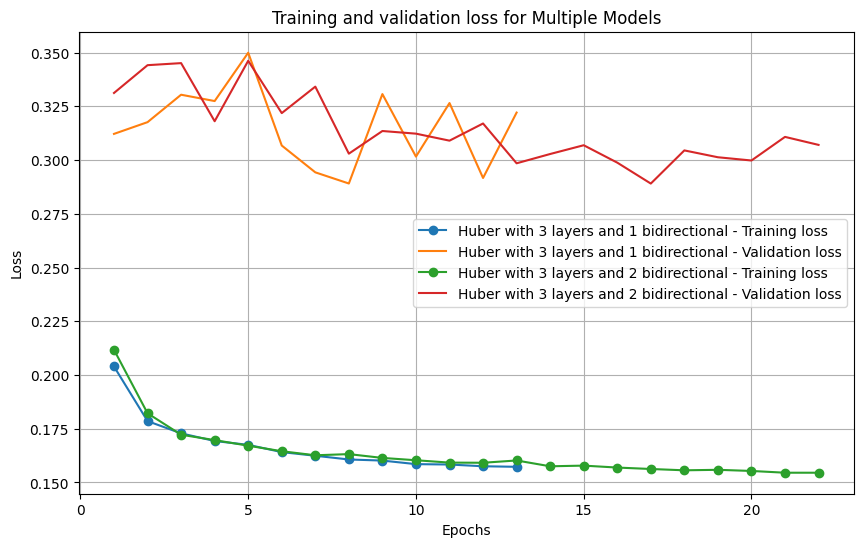

In [ ]:
history_dicts = [model_history_H03_2.history, model_history_H03_2_2.history]

# Define labels for each model
model_labels = ['Huber with 3 layers and 1 bidirectional', 'Huber with 3 layers and 2 bidirectional', 'Huber with 2 layers and 2 bidirectional']

# Create a new figure
plt.figure(figsize=(10, 6))

# Loop through each model's history
for i, history_dict in enumerate(history_dicts):
    error = history_dict['huber_loss']
    val_error = history_dict['val_huber_loss']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(error) + 1)

    # Plot training loss with dots
    plt.plot(epochs, error, 'o-', label=f'{model_labels[i]} - Training loss')

    # Plot validation loss with lines
    plt.plot(epochs, val_error, '-', label=f'{model_labels[i]} - Validation loss')

plt.title('Training and validation loss for Multiple Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
main_model_history = model_history_H03_2_2


### Now I want to try alter the drop out rate and see if overfitting lowers

In [ ]:
patience = 5 #num epochs without improvement

model_3_2_drop_04 = tf.keras.Sequential([
  layers.Bidirectional(
  layers.LSTM(8, input_shape = (window_length, 15), return_sequences=True, activation='tanh')),
  layers.Dropout(0.4),
  layers.Bidirectional(layers.LSTM(8,  return_sequences=True)),
  layers.Dropout(0.4),
  layers.LSTM(4,  return_sequences=False),
  layers.Dropout(0.2),
  layers.Dense(4, activation='linear')])

model_3_2_drop_04.build((None, timesteps, 15))
model_3_2_drop_04.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', verbose=True, restore_best_weights=True)


model_3_2_drop_04.compile(loss=tf.keras.losses.Huber(delta=0.3),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.losses.Huber()])

model_history_3_2_drop_04 = model_3_2_drop_04.fit(train_generator, epochs=100, validation_data= val_generator,  callbacks=[early_stopping], verbose=1)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_34 (Bidirect  (None, 168, 16)           1536      
 ional)                                                          
                                                                 
 dropout_58 (Dropout)        (None, 168, 16)           0         
                                                                 
 bidirectional_35 (Bidirect  (None, 168, 16)           1600      
 ional)                                                          
                                                                 
 dropout_59 (Dropout)        (None, 168, 16)           0         
                                                                 
 lstm_60 (LSTM)              (None, 4)                 336       
                                                                 
 dropout_60 (Dropout)        (None, 4)               

### Same model but with parameter decay

In [ ]:
patience = 5 #num epochs without improvement

model_decay_4 = tf.keras.Sequential([
  layers.Bidirectional(
  layers.LSTM(8, input_shape = (window_length, 15), return_sequences=True, activation='tanh')),
  layers.Dropout(0.4),
  layers.Bidirectional(layers.LSTM(8,  return_sequences=True)),
  layers.Dropout(0.4),
  layers.LSTM(4,  return_sequences=False),
  layers.Dropout(0.2),
  layers.Dense(4, activation='linear')])

model_decay_4.build((None, timesteps, 15))
model_decay_4.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', verbose=True, restore_best_weights=True)


model_decay_4.compile(loss=tf.keras.losses.Huber(delta=0.3),
                optimizer=tf.keras.optimizers.Adam(weight_decay= 1e-4),
                metrics=[tf.keras.losses.Huber()])
model_history_decay_4 = model_decay_4.fit(train_generator, epochs=100, validation_data= val_generator,  callbacks=[early_stopping], verbose=1)

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_38 (Bidirect  (None, 168, 16)           1536      
 ional)                                                          
                                                                 
 dropout_64 (Dropout)        (None, 168, 16)           0         
                                                                 
 bidirectional_39 (Bidirect  (None, 168, 16)           1600      
 ional)                                                          
                                                                 
 dropout_65 (Dropout)        (None, 168, 16)           0         
                                                                 
 lstm_66 (LSTM)              (None, 4)                 336       
                                                                 
 dropout_66 (Dropout)        (None, 4)               

In [ ]:
#More decay


patience = 5 #num epochs without improvement

model_decay_3 = tf.keras.Sequential([
  layers.Bidirectional(
  layers.LSTM(8, input_shape = (window_length, 15), return_sequences=True, activation='tanh')),
  layers.Dropout(0.4),
  layers.Bidirectional(layers.LSTM(8,  return_sequences=True)),
  layers.Dropout(0.4),
  layers.LSTM(4,  return_sequences=False),
  layers.Dropout(0.2),
  layers.Dense(4, activation='linear')])

model_decay_3.build((None, timesteps, 15))
model_decay_3.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', verbose=True, restore_best_weights=True)


model_decay_3.compile(loss=tf.keras.losses.Huber(delta=0.3),
                optimizer=tf.keras.optimizers.Adam(weight_decay= 1e-3),
                metrics=[tf.keras.losses.Huber()])
model_history_decay_3 = model_decay_3.fit(train_generator, epochs=100, validation_data= val_generator,  callbacks=[early_stopping], verbose=1)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_42 (Bidirect  (None, 168, 16)           1536      
 ional)                                                          
                                                                 
 dropout_70 (Dropout)        (None, 168, 16)           0         
                                                                 
 bidirectional_43 (Bidirect  (None, 168, 16)           1600      
 ional)                                                          
                                                                 
 dropout_71 (Dropout)        (None, 168, 16)           0         
                                                                 
 lstm_72 (LSTM)              (None, 4)                 336       
                                                                 
 dropout_72 (Dropout)        (None, 4)               

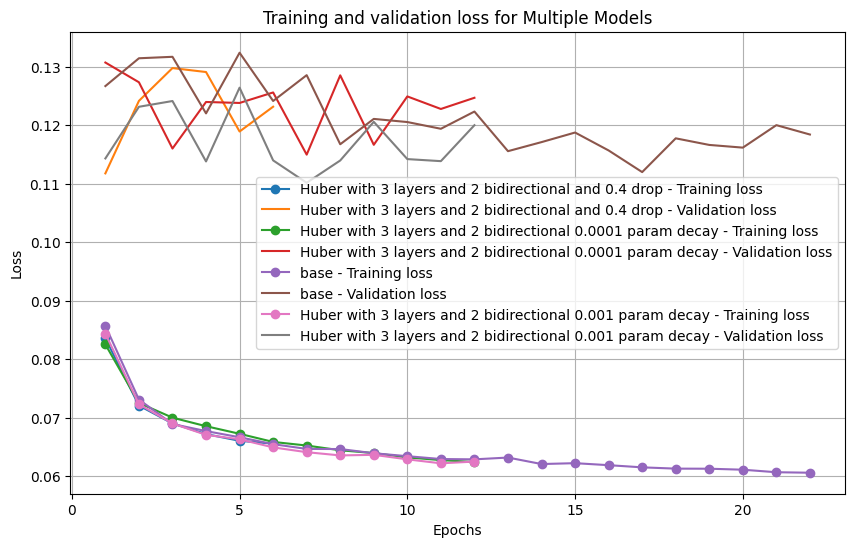

In [ ]:
history_dicts = [model_history_3_2_drop_04.history, model_history_decay_4.history, model_history_H03_2_2.history, model_history_decay_3.history]

# Define labels for each model
model_labels = ['Huber with 3 layers and 2 bidirectional and 0.4 drop', 'Huber with 3 layers and 2 bidirectional 0.0001 param decay', 'base', 'Huber with 3 layers and 2 bidirectional 0.001 param decay']

# Create a new figure
plt.figure(figsize=(10, 6))

# Loop through each model's history
for i, history_dict in enumerate(history_dicts):
    error = history_dict['huber_loss']
    val_error = history_dict['val_huber_loss']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(error) + 1)

    # Plot training loss with dots
    plt.plot(epochs, loss, 'o-', label=f'{model_labels[i]} - Training loss')

    # Plot validation loss with lines
    plt.plot(epochs, val_loss, '-', label=f'{model_labels[i]} - Validation loss')

plt.title('Training and validation loss for Multiple Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
weights = model_decay_3.get_weights()

### Altering learning rate to 0.001 partial decay

In [ ]:
patience = 7 #num epochs without improvement

model_reg= tf.keras.Sequential([
  layers.Bidirectional(
  layers.LSTM(8, input_shape = (window_length, 15), return_sequences=True)),
  layers.Dropout(0.4),
  layers.Bidirectional(layers.LSTM(8,  return_sequences=True)),
  layers.Dropout(0.4),
  layers.LSTM(4,  return_sequences=False),
  layers.Dropout(0.2),
  layers.Dense(4, activation='linear')])

model_reg.build((None, timesteps, 15))
model_reg.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', verbose=True, restore_best_weights=True)


model_reg.compile(loss=tf.keras.losses.Huber(delta=0.3),
                optimizer=tf.keras.optimizers.Adam(weight_decay= 1e-3, learning_rate=0.005),
                metrics=[tf.keras.losses.Huber()])
model_history_learning_005 = model_reg.fit(train_generator, epochs=100, validation_data= val_generator,  callbacks=[early_stopping], verbose=1)

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_48 (Bidirect  (None, 168, 16)           1536      
 ional)                                                          
                                                                 
 dropout_79 (Dropout)        (None, 168, 16)           0         
                                                                 
 bidirectional_49 (Bidirect  (None, 168, 16)           1600      
 ional)                                                          
                                                                 
 dropout_80 (Dropout)        (None, 168, 16)           0         
                                                                 
 lstm_81 (LSTM)              (None, 4)                 336       
                                                                 
 dropout_81 (Dropout)        (None, 4)               

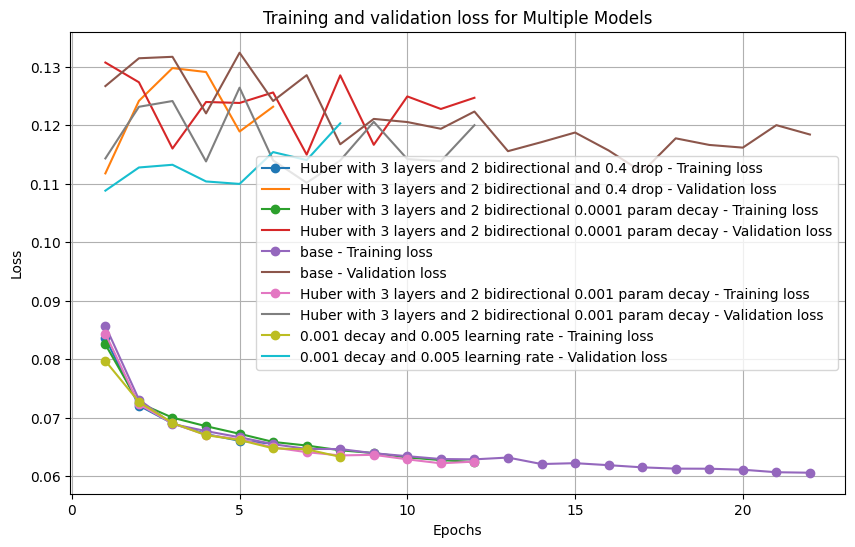

In [ ]:
history_dicts = [model_history_3_2_drop_04.history, model_history_decay_4.history, model_history_H03_2_2.history, model_history_decay_3.history, model_history_learning_005.history]

# Define labels for each model
model_labels = ['0.4 drop', ' 0.0001 param decay', 'base', '0.001 param decay', '0.001 decay and 0.005 learning rate']

# Create a new figure
plt.figure(figsize=(10, 6))

# Loop through each model's history
for i, history_dict in enumerate(history_dicts):
    error = history_dict['huber_loss']
    val_error = history_dict['val_huber_loss']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(error) + 1)

    # Plot training loss with dots
    plt.plot(epochs, loss, 'o-', label=f'{model_labels[i]} - Training loss')

    # Plot validation loss with lines
    plt.plot(epochs, val_loss, '-', label=f'{model_labels[i]} - Validation loss')

plt.title('Training and validation loss for Multiple Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()